In [244]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.formula.api import ols
import researchpy as rp
import os

In [245]:
location = '../../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation'
promoter_pref='promoters_5UTR'
file_names='non-overlapping_includingbidirectional_all_genes_newannotation'
Czechowski_gene_categories = f'../../../data/output/{file_names}/genes/{promoter_pref}_czechowski_constitutive_variable_random.txt'


In [246]:
#make directory for the plots to be exported to
dirName = f'{location}/rolling_window/TFBS_coverage_rw/plots'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/rolling_window/TFBS_coverage_rw/plots  already exists


In [247]:
#bp_covered = '../../data/promoter_analysis/promoters.bp_covered.txt'
bp_covered = f'{location}/rolling_window/TFBS_coverage_rw/{promoter_pref}_bpcovered_rw.bed'
promoter_bed = f'{location}/FIMO/{promoter_pref}.bed'
promoter_no_5UTR = f'{location}/promoters.gff3'

In [248]:
#read in coverage bedfile
coverage_df = pd.read_table(bp_covered, sep='\t', header=None)
col = ['chr','start','stop','name','no._of_overlaps', 'no._of_bases_covered','window_length','fraction_bases_covered']
coverage_df.columns = col
#add % bases covered column
coverage_df['percentage_bases_covered'] = coverage_df.fraction_bases_covered * 100

In [249]:
coverage_df

,chr,start,stop,name,no._of_overlaps,no._of_bases_covered,window_length,fraction_bases_covered,percentage_bases_covered
0,1,2659,2759,AT1G01010_21,0,0,100,0.00,0.0
1,1,2709,2809,AT1G01010_20,0,0,100,0.00,0.0
2,1,2759,2859,AT1G01010_19,0,0,100,0.00,0.0
3,1,2809,2909,AT1G01010_18,0,0,100,0.00,0.0
4,1,2859,2959,AT1G01010_17,0,0,100,0.00,0.0
...,...,...,...,...,...,...,...,...,...
363248,5,26971348,26971448,AT5G67640_17,0,0,100,0.00,0.0
363249,5,26971398,26971498,AT5G67640_18,0,0,100,0.00,0.0
363250,5,26971448,26971548,AT5G67640_19,2,15,100,0.15,15.0
363251,5,26971498,26971598,AT5G67640_20,2,24,100,0.24,24.0


In [250]:
#allow colour codes in seaborn
sns.set(color_codes=True)
sns.set_style("whitegrid")

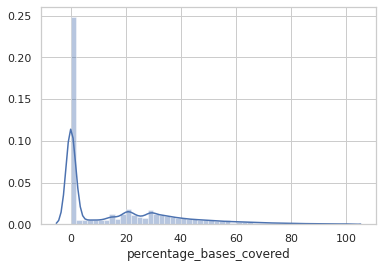

In [251]:
dist_plot = coverage_df['percentage_bases_covered']
#create figure with no transparency
dist_plot_fig = sns.distplot(dist_plot).get_figure()

#save to file
#dist_plot_fig.savefig(f'{location}/TFBS_coverage/plots/bp_covered_dist.pdf', format='pdf')


In [252]:
#Add AGI and window_number column to coverage_df
coverage_df = coverage_df.assign(AGI=coverage_df.name.str.extract(r'(.*?)\_'))
coverage_df['window_number'] = coverage_df.name.str.split('_', n=2, expand = True)[1]
#coverage_df = coverage_df.assign(window_number=coverage_df.name.str[-1:])
coverage_df


,chr,start,stop,name,no._of_overlaps,no._of_bases_covered,window_length,fraction_bases_covered,percentage_bases_covered,AGI,window_number
0,1,2659,2759,AT1G01010_21,0,0,100,0.00,0.0,AT1G01010,21
1,1,2709,2809,AT1G01010_20,0,0,100,0.00,0.0,AT1G01010,20
2,1,2759,2859,AT1G01010_19,0,0,100,0.00,0.0,AT1G01010,19
3,1,2809,2909,AT1G01010_18,0,0,100,0.00,0.0,AT1G01010,18
4,1,2859,2959,AT1G01010_17,0,0,100,0.00,0.0,AT1G01010,17
...,...,...,...,...,...,...,...,...,...,...,...
363248,5,26971348,26971448,AT5G67640_17,0,0,100,0.00,0.0,AT5G67640,17
363249,5,26971398,26971498,AT5G67640_18,0,0,100,0.00,0.0,AT5G67640,18
363250,5,26971448,26971548,AT5G67640_19,2,15,100,0.15,15.0,AT5G67640,19
363251,5,26971498,26971598,AT5G67640_20,2,24,100,0.24,24.0,AT5G67640,20


In [253]:
#calculate mean of each window number
def window_means(df,column):
    """function to calculate means of a column for each window number in a df"""
    groupby_window = df.groupby('window_number')
    #output = DataFrame()
    d = []
    for type, value in groupby_window['percentage_bases_covered']:
        d.append({'window':type, 'mean_TFBScoverage':value.mean()})
    output = pd.DataFrame(d)
    #sort by window no.
    output = output.astype({'window': 'int64'})
    output.sort_values(['window'], inplace=True, ignore_index=True)
    return output
    #need to make a df with means of %bpcovered for each window number
    #Then make a graph see https://edinburgh-genome-foundry.github.io/DnaFeaturesViewer/examples/with_gc_plot.html
    

In [254]:
# def window_plot(coverage_df, ax):
#     """function to plot the window for the length of the windows"""
#     y=coverage_df.percentage_bases_covered
#     x=coverage_df.window_number
    
#     #no_of_windows = int(len(coverage_df.window_number.unique()))
#    # xx = np.arange((no_of_windows * (window_length-window_offset)) - window_length) + window_offset
    

    

In [359]:
def windows_coords(promoter_bed,promoter_no_5UTR,coverage_df, genetype=False):
    """function to add the centre of each window corresponding to each window no. and return a lineplot"""
    #read in bed file
    promoter_df = pd.read_table(promoter_bed, sep='\t', header=None)
    col = ['chr','start','stop','AGI','dot1', 'strand','source','type','dot2','attributes']
    promoter_df.columns = col
    #add promoter length column
    promoter_df['length'] = promoter_df.stop-promoter_df.start
    #merge promoter_bed with overeage_df on AGI
    merged = pd.merge(coverage_df, promoter_df, on='AGI',  how='left',suffixes=('','_wholeprom')) 
    #calculate longest promoter length
    length_of_longest_promoter = merged.length.max()
    #make columns integars
    merged = merged.astype({'stop_wholeprom':'int','start_wholeprom':'int','start':'int','stop':'int'})
    #split merged into 2 dfs by strand
    pos = merged[merged.strand == '+'].copy()
    neg = merged[merged.strand == '-'].copy()
    
    #add coverage position column where position is the middle of the window, with whole length of the longest promoter
    pos['position'] = (pos.stop_wholeprom) - (pos.start+0.5*(pos.stop-pos.start))
    neg['position'] = (neg.start+0.5*(neg.stop-neg.start)) - neg.start_wholeprom
    merged2 = pd.merge(pos,neg,how='outer')

    merged2 = merged2.astype({'position': 'int64'})
    #get longest transcript TSS distribution (if Araport 11 definition used)
    promoter_no_5UTR_df = pd.read_table(promoter_no_5UTR, sep='\t', header=None)
    col = ['chr', 'source', 'type', 'start','stop', 'dot1','strand','dot2','attributes']
    promoter_no_5UTR_df.columns = col
    #add AGI column
    promoter_no_5UTR_df_agi = promoter_no_5UTR_df.assign(AGI=promoter_no_5UTR_df.attributes.str.extract(r'ID=gene:(.*?)\;'))
    
    merged2 = pd.merge(merged2,promoter_no_5UTR_df_agi, on='AGI', how='left', suffixes=('','_no_UTR'))
    #remove NaN (promoters in promoters.gff but not in promoters_5UTR)
    merged2 = merged2[merged2.length.notnull()]
    #remove NaN (promoters in promoters_5UTR but not in promoters.gff - ie. only 5'UTRs)
    merged2 = merged2[merged2.chr_no_UTR.notnull()]

    #make 0 start like in bed files
    merged2.start_no_UTR = merged2.start_no_UTR -1
    #add TSS locationcolumn
    #merged2['TSS'] = int()
    merged2.loc[merged2.strand == '+', 'TSS'] = merged2.loc[merged2.strand == '+', 'stop_no_UTR']
    merged2.loc[merged2.strand == '-', 'TSS'] = merged2.loc[merged2.strand == '-', 'start_no_UTR'] -1
    #transform TSS location in the same way as the coverage position column
    merged2.loc[merged2.strand == '-', 'TSS_transformed'] = merged2.loc[merged2.strand == '-', 'TSS'] - merged2.loc[merged2.strand == '-','start_wholeprom']
    merged2.loc[merged2.strand == '+', 'TSS_transformed'] = merged2.loc[merged2.strand == '+', 'stop_wholeprom'] - merged2.loc[merged2.strand == '+', 'TSS']
    #make integars
    merged2 = merged2.astype({'start_no_UTR':'int','stop_no_UTR':'int','TSS':'int','TSS_transformed':'int'})
    #return merged2[['AGI','strand','start','stop','start_wholeprom','stop_wholeprom','start_no_UTR','stop_no_UTR','TSS','TSS_transformed','position','chr_no_UTR','window_number']]
    #make all values of interest negative as upstream from ATG
    merged_positive = merged2.copy()
    merged2[['length','TSS_transformed','position']] = -merged2[['length','TSS_transformed','position']]

    if genetype==False:
        #make subplots
        f, axes = plt.subplots(3, figsize=(10,8))
        length_of_longest_promoter = merged_positive.length.max()
        
        #TSS distribution
        sns.distplot(merged2.TSS_transformed, ax=axes[0])
        #promoter length dist_plot
        sns.distplot(merged2.length, ax=axes[1])

        #lineplot
        sns.lineplot(y=merged2.percentage_bases_covered, x=merged2.position, ax=axes[2]) 
        #set titles
        axes[0].set_title(f'All promoters TSS distribution', weight='bold')
        #density is kernal density estimation
        axes[0].set_ylabel('Density')
        axes[0].set_xlabel('')
        axes[0].set_xticklabels([])
        axes[1].set_title(f'All promoters length distribution', weight='bold')  
        axes[1].set_ylabel('Density')
        axes[1].set_xlabel('')
        axes[1].set_xticklabels([])
        axes[2].set_title(f'All promoters sliding windows % bp covered', weight='bold')
        axes[2].set_ylabel('mean % bp covered')
        axes[2].set_xlabel('position upstream of ATG')
        
        #for all subplots:
        for n in axes:
            #remove grids
            n.grid(False)
            n.set_xlim([-length_of_longest_promoter,0])
            
            
            
        f.tight_layout()
               
    else:
        #filter so only genetype subset present
        merged2 = merged2[merged2.gene_type.notnull()]
        #make subplots
        f, axes = plt.subplots(3, figsize=(10,8))
        length_of_longest_promoter = merged_positive[merged_positive.gene_type.notnull()].length.max()
        
        #TSS distribution
        sns.distplot(merged2[merged2.gene_type == genetype].TSS_transformed, ax=axes[0])
        #promoter length dist_plot
        sns.distplot(merged2[merged2.gene_type == genetype].length, ax=axes[1])

        #lineplot
        sns.lineplot(y=merged2[merged2.gene_type == genetype].percentage_bases_covered, x=merged2[merged2.gene_type == genetype].position, ax=axes[2]) 
        #set titles
        axes[0].set_title(f'{genetype} TSS distribution', weight='bold')
        #density is kernal density estimation
        axes[0].set_ylabel('Density')
        axes[0].set_xlabel('')
        axes[0].set_xticklabels([])
        axes[1].set_title(f'{genetype} promoter length distribution', weight='bold')  
        axes[1].set_ylabel('Density')
        axes[1].set_xlabel('')
        axes[1].set_xticklabels([])
        axes[2].set_title(f'{genetype} promoter sliding windows % bp covered', weight='bold')
        axes[2].set_ylabel('mean % bp covered')
        axes[2].set_xlabel('position upstream of ATG')
        
        #for all subplots:
        for n in axes:
            #remove grids
            n.grid(False)
            n.set_xlim([-length_of_longest_promoter,0])
            
            
            
        f.tight_layout()
               

    
    
    
    return merged2

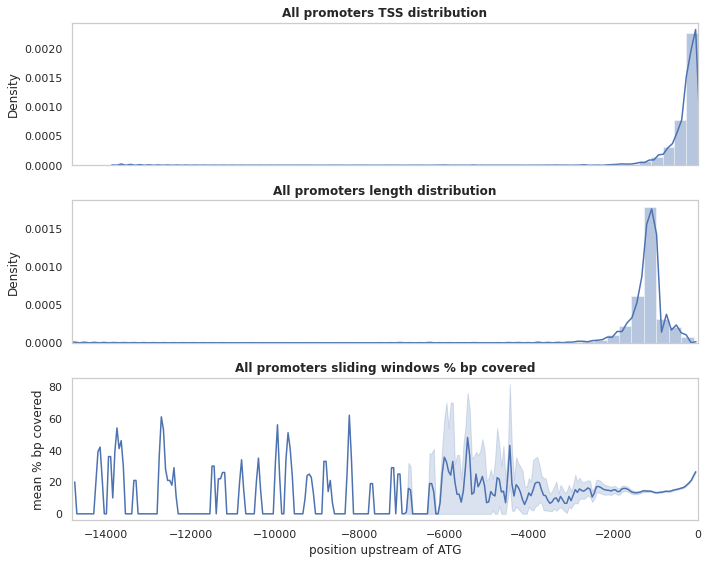

In [360]:
#all promoters in genome
merged = windows_coords(promoter_bed,promoter_no_5UTR,coverage_df)


## Now do constitutive and variable promoter from Czechowski et al 2005

In [259]:
def add_genetype(coverage,gene_categories):
    """function to add gene type to the df, and remove random genes"""
    select_genes = pd.read_table(gene_categories, sep='\t', header=None)
    cols = ['AGI', 'gene_type']
    select_genes.columns = cols

    merged = pd.merge(select_genes, coverage, on='AGI', how='left')   
   # no_random = merged_renamed[merged_renamed.gene_type != 'random']
  #  no_random.reset_index(drop=True, inplace=True)
    
    return merged

In [260]:
coverage_prom_types = add_genetype(coverage_df, Czechowski_gene_categories)

In [267]:
coverage_prom_types

,AGI,gene_type,chr,start,stop,name,no._of_overlaps,no._of_bases_covered,window_length,fraction_bases_covered,percentage_bases_covered,window_number
0,AT1G01060,constitutive,1,37061,37161,AT1G01060_1,0,0,100,0.00,0.0,1
1,AT1G01060,constitutive,1,37111,37211,AT1G01060_2,1,14,100,0.14,14.0,2
2,AT1G01060,constitutive,1,37161,37261,AT1G01060_3,1,24,100,0.24,24.0,3
3,AT1G01060,constitutive,1,37211,37311,AT1G01060_4,1,10,100,0.10,10.0,4
4,AT1G01060,constitutive,1,37261,37361,AT1G01060_5,0,0,100,0.00,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
5176,AT4G23880,control,4,12417238,12417338,AT4G23880_18,0,0,100,0.00,0.0,18
5177,AT4G23880,control,4,12417288,12417388,AT4G23880_19,0,0,100,0.00,0.0,19
5178,AT4G23880,control,4,12417338,12417438,AT4G23880_20,0,0,100,0.00,0.0,20
5179,AT4G23880,control,4,12417388,12417488,AT4G23880_21,0,0,100,0.00,0.0,21


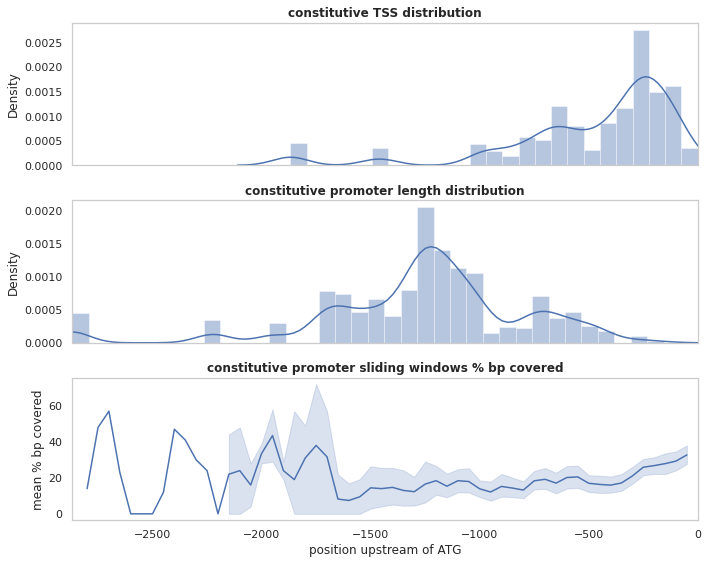

In [361]:
constitutive_rolling = windows_coords(promoter_bed,promoter_no_5UTR,coverage_prom_types, genetype='constitutive')
#figure legend:
# 1) Sliding windows of 100bp with 50bp offset were taken across each promoter. 
# 2) Window 1 is the 100bp immediately upstream of the ATG. Window 2 is offset 50bp further upstream of this and so on.
# 3) The coordinate of the middle of each window was used for each data point on the plot x axis
# 4) % bp covered by TFBSs in each window were calculated. The mean % bp covered for each window position (ie. mean of all window 1s, mean of all window 2s etc) across all promoters was calculated and used for the y-axis
# 5) The x-axis range was set to the longest promoter in the dataset
# 6) 95% confidence intervals

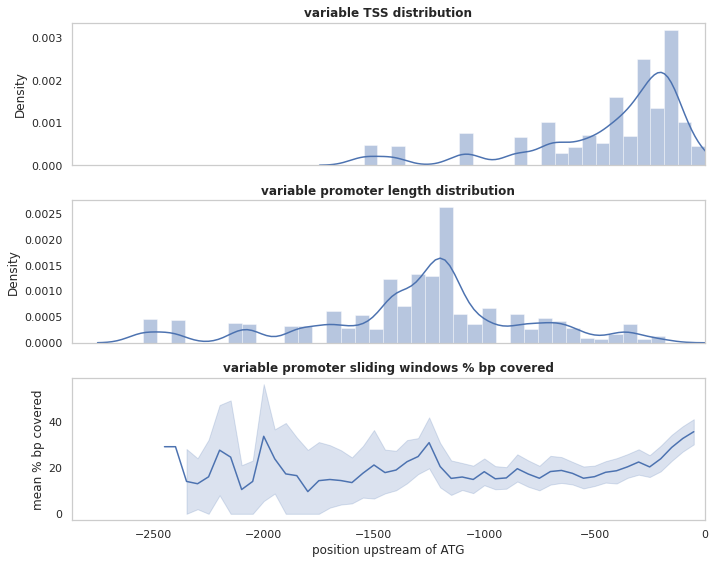

In [352]:
variable_rolling = windows_coords(promoter_bed,promoter_no_5UTR,coverage_prom_types,genetype='variable')

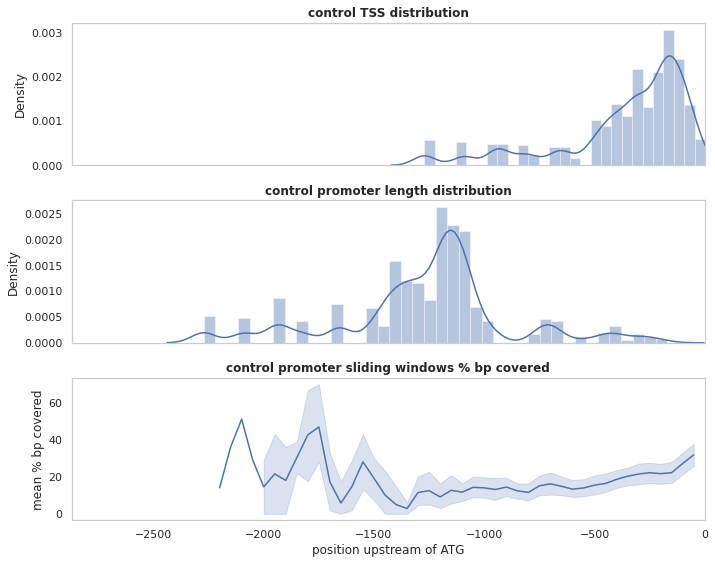

In [353]:
random_rolling = windows_coords(promoter_bed,promoter_no_5UTR,coverage_prom_types,genetype='control')